# Importing libraries

In [292]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
plt.style.use('seaborn-darkgrid')
tqdm.pandas()

# Loading the data
The warning is fine because columns with mixed types get converted to objects. 
We'll make sure everything has the right type in the next cell.

In [432]:
nrows = None #Sizing down the dataset is useful for prototyping and evaluating computational times
df = pd.read_csv('Fire_Department_Calls_for_Service.csv', nrows=nrows)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (19,20,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data cleaning 
Everything not explicitly handled here should have type "object"

In [433]:
#Data dictionary so we can make sure everything is the right type
data_dict = pd.read_csv('DataDictionary.csv')

#List of datetime columns
date_columns = list(data_dict[data_dict['Data Type'] == 'Date & Time']['Field Name'])

#This column appears to be missing
date_columns.remove('AVL Validated On Scene DtTm')

#Converting to datetimes
for column in date_columns:
    #Specifying the formats makes date parsing way faster even though it's not elegant
    if "Date" in column:
        df[column] = pd.to_datetime(df[column], format='%m/%d/%Y')
    else:
        df[column] = pd.to_datetime(df[column], format='%m/%d/%Y %I:%M:%S %p')
        
#List of numeric columns
numeric_columns = list(data_dict[data_dict['Data Type'] == 'Numeric']['Field Name'])

#Really these should be ints, but the float type lets us leave missing values as nans
df[numeric_columns] = df[numeric_columns].astype(float)
       
#List of boolean columns
bool_columns = list(data_dict[data_dict['Data Type'] == 'Boolean (True/False)']['Field Name'])
df[bool_columns] = df[bool_columns].astype(bool)

#Serialize the cleaned dataframe so we don't have to wait as long if we need to reload data
df.to_pickle('cleaned_fire_data')
        

# Task 1

## Adding turnout time and hour of day to dataframe

In [434]:
#Simple subtraction of response timestamp (enroute) and dispatch timestamp
df['turnout_time'] = df['Response DtTm'] - df['Dispatch DtTm']

#Converting the time delta to seconds
df['turnout_time'] = df['turnout_time'].progress_apply(lambda x: x.total_seconds())

#Adding hour of day based on when the call was received
df['hour'] = df['Received DtTm'].progress_apply(lambda x: x.hour)

#Adding boolean variable that indicates whether call is recieved during daytime or evening hours
daytime_hours = np.arange(6,22)
df['daytime'] = df['hour'].isin(daytime_hours)


100%|██████████| 5272824/5272824 [00:38<00:00, 135616.01it/s][A

100%|██████████| 5272824/5272824 [00:19<00:00, 274348.70it/s][A


## Making a new dataframe containing only rows where the turnout time is defined

In [439]:
turnout_df = df[~np.isnan(df['turnout_time'])].reset_index(drop=True)
#Turnout time should be positive
turnout_df = turnout_df[turnout_df['turnout_time']>0]

## What does the distribution of turnout times look like?
It's skewed right

Text(0, 0.5, 'Frequency')

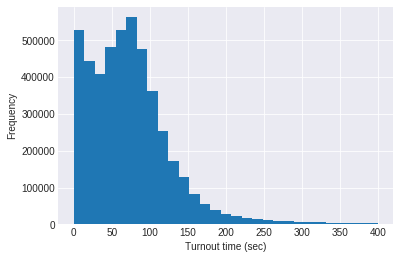

In [440]:
plt.hist(turnout_df['turnout_time'], bins=np.linspace(0,400,30))
plt.xlabel('Turnout time (sec)')
plt.ylabel('Frequency')

## Median turnout time by hour of day
I chose the median over the mean because of the skewness of the data and the presence of outliers

Text(0, 0.5, 'Median turnout time (sec)')

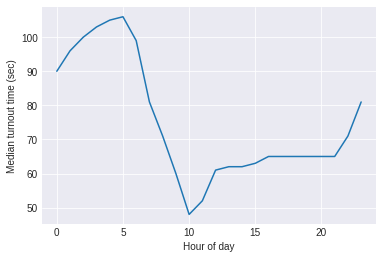

In [441]:
median_turnout = turnout_df[['hour','turnout_time']].groupby('hour').aggregate(np.median).reset_index()
plt.plot(median_turnout['hour'], median_turnout['turnout_time'])
plt.xlabel('Hour of day')
plt.ylabel('Median turnout time (sec)')

## CDF plot to compare daytime vs. evening turnout times
As expected, turnout times are generally longer for evening calls, but the previous plot reveals a spike 
specifically between 4:00-5:00 AM

Text(0, 0.5, 'Percentile')

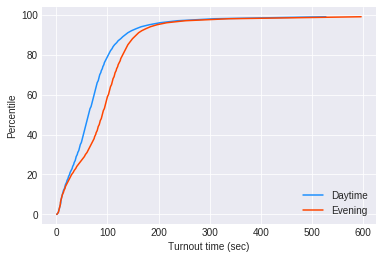

In [442]:
percentiles = np.arange(0,100)
daytime_values = np.percentile(turnout_df[turnout_df['daytime']]['turnout_time'], percentiles)
plt.plot(daytime_values, percentiles, color='dodgerblue')
evening_values = np.percentile(turnout_df[~turnout_df['daytime']]['turnout_time'], percentiles)
plt.plot(evening_values, percentiles, color='orangered')
plt.legend(['Daytime', 'Evening'])
plt.xlabel('Turnout time (sec)')
plt.ylabel('Percentile')

## Looking at back to back responses

In [443]:
#adding "last available" column
turnout_df = turnout_df.sort_values(by='Available DtTm')
turnout_df['last_available'] = turnout_df.groupby('Unit ID')['Available DtTm'].transform(lambda x: x.shift(1))
turnout_df = turnout_df.reset_index(drop=True)

turnout_df['time_since_available'] = turnout_df['Dispatch DtTm'] - turnout_df['last_available']
turnout_df['time_since_available'] = turnout_df['time_since_available'].progress_apply(lambda x: x.total_seconds())
#Should be positive
turnout_df = turnout_df[turnout_df['time_since_available'] > 0]

#Identifying incidents that are dispatched within 10 minutes (600 seconds) of when they were last available
#Note, some rows were dropped because of missing values. I don't think this should affect the analysis much.
turnout_df['back_to_back'] = turnout_df['time_since_available'] < 600


100%|██████████| 4745315/4745315 [00:35<00:00, 134419.48it/s][A


In [517]:
unit = turnout_df['Unit ID'].iloc[0]
unit_df = turnout_df[turnout_df['Unit ID'] == unit].reset_index()


## CDF comparing turnout times with back to back responses
It looks like back to back incidents actually have faster turnout times
I might have done something wrong, but I expected this instead of what was described in the instructions. 

The reasoning is that the units are already "ready to go" if they just got back from an incident.

Text(0, 0.5, 'Percentile')

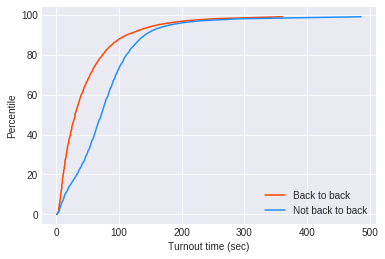

In [445]:
percentiles = np.arange(0,100)
back_to_back = np.percentile(turnout_df[turnout_df['back_to_back']]['turnout_time'], percentiles)
plt.plot(back_to_back, percentiles, color='orangered')

not_back_to_back= np.percentile(turnout_df[turnout_df['back_to_back']==False]['turnout_time'], percentiles)
plt.plot(not_back_to_back, percentiles, color='dodgerblue')
plt.legend(['Back to back', 'Not back to back'])
plt.xlabel('Turnout time (sec)')
plt.ylabel('Percentile')

# Task 2

In [446]:
df['end_on_scene'] = df[['Available DtTm', 'Transport DtTm']].min(axis=1)
df['time_on_scene'] = df['end_on_scene'] - df['On Scene DtTm'] 
df['time_on_scene'] = df['time_on_scene'].progress_apply(lambda x: x.total_seconds())


100%|██████████| 5272824/5272824 [00:35<00:00, 147925.97it/s]


In [449]:
#Removing outliers to help with analysis
on_scene = df[df['time_on_scene'] < 6000]
on_scene = on_scene[on_scene['time_on_scene'] > 0]
on_scene = on_scene[on_scene['turnout_time'] < 600]
on_scene = on_scene[on_scene['turnout_time'] > 0]

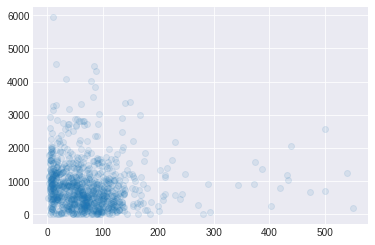

In [455]:
#Random sample from dataframe. Plotting 5 million points is overkill
sample = on_scene.sample(1000)
plt.scatter(sample['turnout_time'], sample['time_on_scene'], alpha=0.1)

## Pearsons R. Quantifies the correlation between the two quantities
It's basically zero, so I don't believe that there is a positive relationship between turnout time and time on scene


In [457]:
on_scene[['time_on_scene','turnout_time']].corr().iloc[0,1]

-0.04778879250664331

# Task 3

In [519]:
df['call_duration'] = df['Available DtTm'] - df['Dispatch DtTm']
df['call_duration'] = df['call_duration'].progress_apply(lambda x: x.total_seconds())
call_time_df = df.dropna(subset=['call_duration'], axis=0)

#Use only positive call durations
call_time_df = call_time_df[call_time_df['call_duration'] > 0]



  0%|          | 0/5272824 [00:00<?, ?it/s]

  0%|          | 1/5272824 [00:37<54449:33:30, 37.18s/it]

  2%|▏         | 97716/5272824 [00:37<37408:21:24, 26.02s/it]

  4%|▍         | 199586/5272824 [00:37<25670:23:30, 18.22s/it]

  6%|▌         | 302594/5272824 [00:37<17604:25:23, 12.75s/it]

  8%|▊         | 408540/5272824 [00:37<12060:24:57,  8.93s/it]

 10%|▉         | 514264/5272824 [00:37<8258:48:01,  6.25s/it] 

 12%|█▏        | 629728/5272824 [00:37<5640:53:01,  4.37s/it]

 14%|█▍        | 743229/5272824 [00:37<3852:05:40,  3.06s/it]

 16%|█▋        | 860696/5272824 [00:37<2626:32:18,  2.14s/it]

 18%|█▊        | 975288/5272824 [00:38<1790:49:32,  1.50s/it]

 21%|██        | 1092077/5272824 [00:38<1219:30:40,  1.05s/it]

 23%|██▎       | 1203000/5272824 [00:38<831:00:32,  1.36it/s] 

 25%|██▌       | 1321968/5272824 [00:38<564:42:08,  1.94it/s]

 27%|██▋       | 1442064/5272824 [00:38<383:16:33,  2.78it/s]

 30%|██▉       | 1558154/5272824 [00:38<260:09:46,  3.97it/s]

 32%|█

## Feature exploration
Data is skewed, so a log transformation might be a good idea for visualization

### Histogram of untransformed data

Text(0, 0.5, 'frequency')

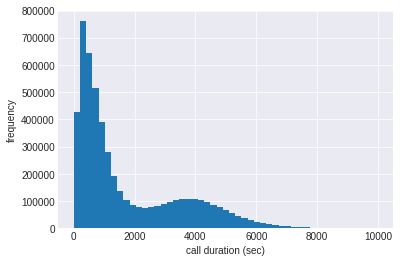

In [520]:
hist = plt.hist(call_time_df['call_duration'], bins = np.linspace(0,10000,50))
plt.xlabel('call duration (sec)')
plt.ylabel('frequency')

### Log histogram
Interesting... Looks like two distinct Gaussians now, so that means two distinct log-normal distributions.

Text(0, 0.5, 'frequency')

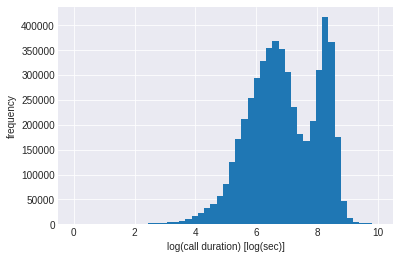

In [521]:
hist = plt.hist(np.log(call_time_df['call_duration']), bins = np.linspace(0,10,50))
plt.xlabel('log(call duration) [log(sec)]')
plt.ylabel('frequency')

### Time of day

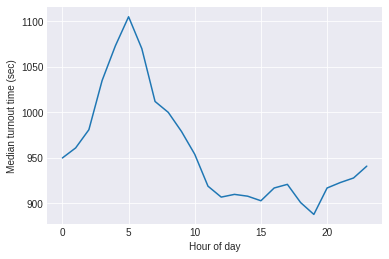

In [522]:
median_call_time = call_time_df[['hour','call_duration']].groupby('hour').aggregate(np.median).reset_index()
plt.plot(median_call_time['hour'], median_call_time['call_duration'])
plt.xlabel('Hour of day')
plt.ylabel('Median turnout time (sec)')

#We'll keep track of the features we want to use in the model
important_features = []
important_features = important_features + list(pd.get_dummies(median_call_time,  columns=['hour']).columns)

### Unit type
PRIVATE and MEDIC appear to be linked to longer call durations, engines are linked to shorter durations

Unit Type_ENGINE   -0.302675
Unit Type_MEDIC     0.392475
Name: call_duration, dtype: float64


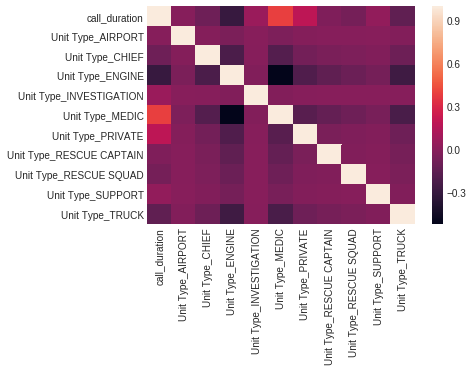

In [523]:
columns = ['call_duration', 'Unit Type']
subset = pd.get_dummies(df[columns])
sns.heatmap(subset.corr())

#Anything with a absolute value of pearson's R greater than 0.2, we'll include in our model
correlations = subset.corr()['call_duration']
correlations = correlations[np.abs(correlations)>0.2].drop('call_duration')
print(correlations)
important_features = important_features + list(correlations.index)


### Call type
Medical calls are longer; alarm calls are shorter

Call Type_Medical Incident    0.211696
Name: call_duration, dtype: float64


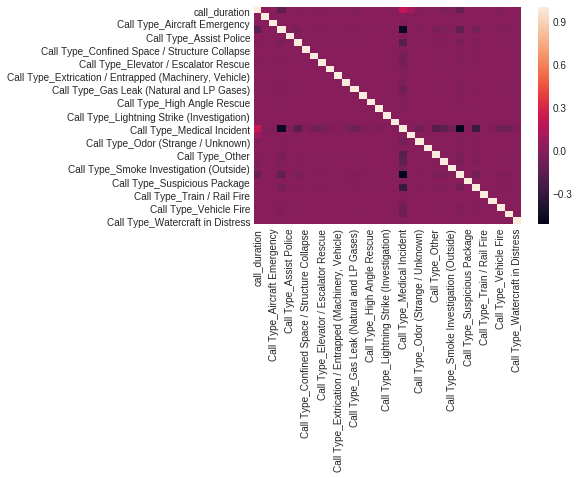

In [524]:
columns = ['call_duration', 'Call Type']
subset = pd.get_dummies(call_time_df[columns])
sns.heatmap(subset.corr())
#Anything with a absolute value of pearson's R greater than 0.2, we'll include in our model
correlations = subset.corr()['call_duration']
correlations = correlations[np.abs(correlations)>0.2].drop('call_duration')
print(correlations)
important_features = important_features + list(correlations.index)

### Call priority

Series([], Name: call_duration, dtype: float64)


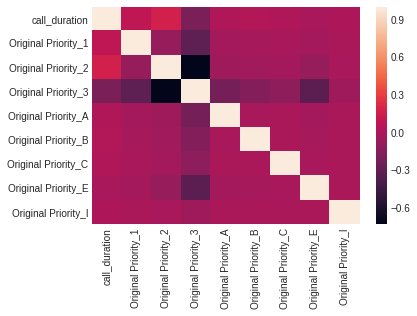

In [525]:
columns = ['call_duration', 'Original Priority']
subset = pd.get_dummies(call_time_df[columns])
sns.heatmap(subset.corr())
#Anything with a absolute value of pearson's R greater than 0.2, we'll include in our model
correlations = subset.corr()['call_duration']
correlations = correlations[np.abs(correlations)>0.2].drop('call_duration')
print(correlations)
important_features = important_features + list(correlations.index)

### Number of alarms
Almost every value is one, so we won't use it

In [526]:
call_time_df['Number of Alarms'].value_counts()

1.0    5175419
2.0      12550
3.0       4182
4.0       1467
5.0        469
Name: Number of Alarms, dtype: int64

## Building the model
Random Forest is a good off-the-shelf model when we're short on time

### One-hot encoding the variables
This means that for every category, we make a boolean variable

In [527]:
columns = ['hour', 'Unit Type', 'Call Type']
important_features = important_features[important_features != 'call_duration']
#The random forest algorithm takes too long with all the data, so we'll just use a sample instead

sample = call_time_df.sample(100000)

y = np.log(sample['call_duration'])
X = pd.get_dummies(sample[columns], columns=columns)

### Fitting the model. 
In order to evaluate performance, we throw out 20% of the data. The model trains on the remaining 80%. 
Then we evaluate the predictions on the "out of sample" data. With more time, I would do hyperparameter tuning, but RF is generally pretty good without it

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor( n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Text(0, 0.5, 'actual log(call duration)')

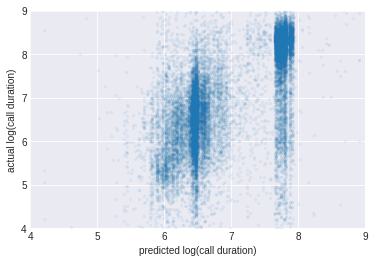

In [529]:
plt.scatter(y_pred, y_test, alpha=0.05, s=5)
plt.xlim(4,9)
plt.ylim(4,9)
plt.xlabel('predicted log(call duration)')
plt.ylabel('actual log(call duration)')

### We'll use the R^2 metric (in log space)  to evaluate the predictions
This is the fraction of the variance that the model is able to explain. This is not great, but it's better than I expected. It seems the model is able to group the call durations into two main "clusters", but there is still a lot of error

In [530]:
SST = np.sum((y_test-np.mean(y_test))**2)
SSE = np.sum((y_test-y_pred)**2)
print(1-SSE/SST)

0.3361642984589507
